# Implementing a Perceptron Algorithm

## Abstract

Link to [perceptron source code](https://github.com/EpicET/EpicET.github.io/blob/main/posts/blog4/perceptron.py).

In [1]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer


Cells 1 to 7 has been directly adapted from Prof. Phil's code. Cell 8 is slightly modified from the original code.
The code below in the sets up the necessary functions to implement a perceptron algorithm.

In [2]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X: torch.Tensor, y: torch.Tensor, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w: torch.Tensor, x_min: int, x_max: int, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


### Test the Perceptron Algorithm
This tests the Perceptron to see if the loss does reach 0.

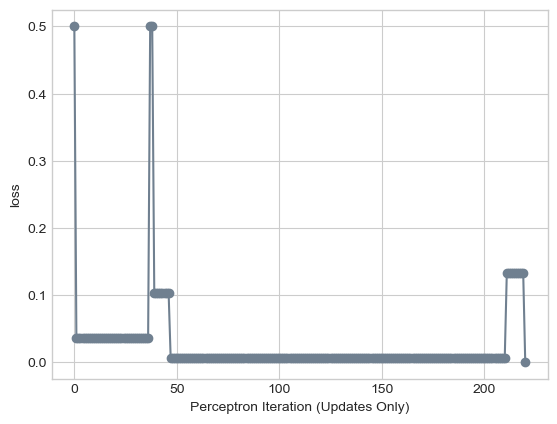

In [7]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

## Experiment 1
This plots the decision boundary and the data points over time.

Ran out of axes to plot. Stopping early.


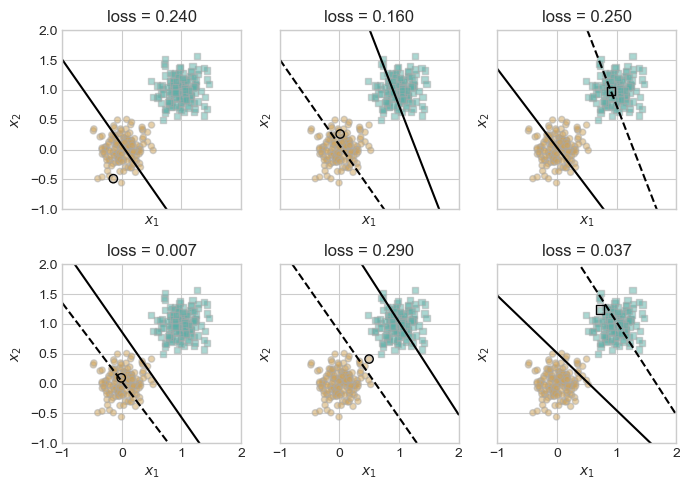

In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    
    # Making sure we don't run out of axes
    if current_ax >= len(axarr.ravel()):
        print("Ran out of axes to plot. Stopping early.")
        break
    
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

## Experiment 2

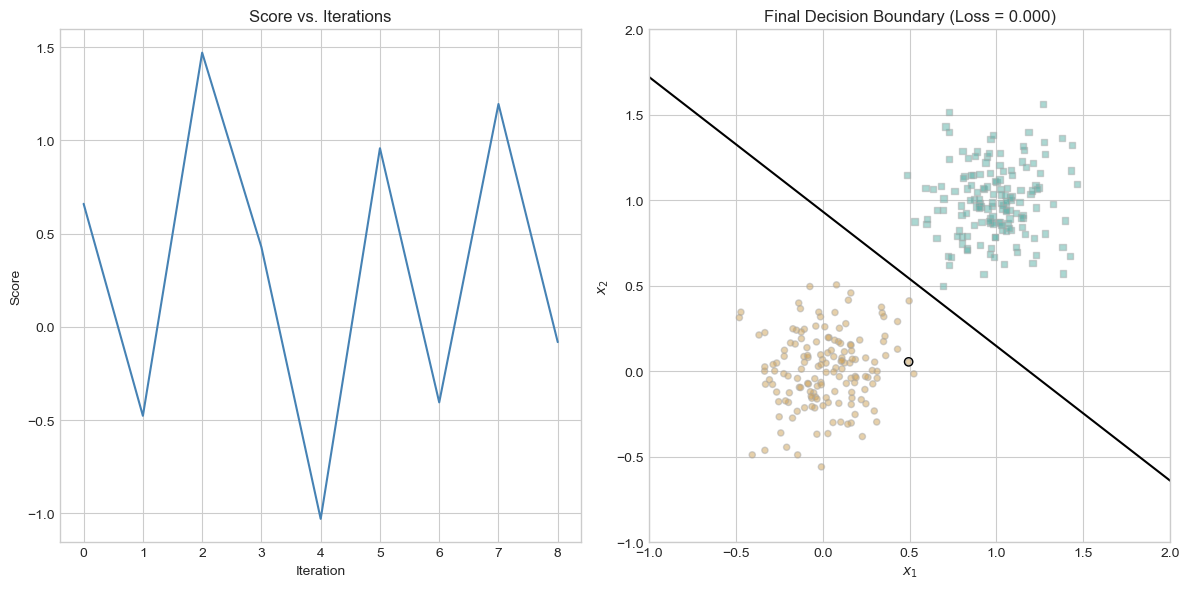

In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
current_ax = 0

loss = 1
score_vec = [] 

while loss > 0 and len(score_vec) <= 1000:

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    score = p.score(X).mean()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    if local_loss > 0:
        loss = p.loss(X, y).item()
        score = p.score(X).mean()
        score_vec.append(score)

# plot the score over iterations
axarr[0].plot(range(len(score_vec)), score_vec, color="steelblue", label="Score")
axarr[0].set_title("Score vs. Iterations")
axarr[0].set_xlabel("Iteration")
axarr[0].set_ylabel("Score")

# Plot the final decision boundary
plot_perceptron_data(X, y, axarr[1])
draw_line(p.w, x_min=-1, x_max=2, ax=axarr[1], color="black")
axarr[1].scatter(X[i, 0], X[i, 1], color="black", facecolors="none", edgecolors="black")
axarr[1].set_title(f"Final Decision Boundary (Loss = {loss:.3f})")
axarr[1].set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()


## Experiment 3

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=5)

torch.Size([300, 6])


In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss = 1
score_vec = [] 

while loss > 0 and len(score_vec) <= 1000:

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)
    
    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    prev_length = len(score_vec)
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    score = p.score(X).mean()

    if local_loss > 0:
        opt.step(x_i, y_i)
    
    if local_loss > 0:
        loss = p.loss(X, y).item()
        score = p.score(X).mean()
        score_vec.append(score)
    
    if(len(score_vec) != prev_length):
        print(f"Iteration {len(score_vec)}: Loss = {loss:.3f}, Score = {score:.3f}")

Iteration 1: Loss = 0.027, Score = 0.699
Iteration 2: Loss = 0.247, Score = -0.777
Iteration 3: Loss = 0.103, Score = 2.712
Iteration 4: Loss = 0.003, Score = 1.483
Iteration 5: Loss = 0.000, Score = -0.228


## Minibatch Perceptron